In [1]:
import numpy as np
import pandas as pd
from subprocess import Popen, PIPE, DEVNULL
import glob

In [2]:
# constants
num_chrom = 9
max_chrom_len = 10000000
num_rows = np.logspace(1, 7, base=10).astype(int)

In [3]:
def random_sort(i, seed, size, group):
    p1 = Popen([
        "gia", "random", f"-n{i}", f"-l{size}", f"-m{max_chrom_len}", f"-c{num_chrom}", f"-s{seed}"
    ], stdout=PIPE)
    p2 = Popen([
        "gia", "sort", f"-odata/random_{i}_{group}.bed"
    ], stdin=p1.stdout)
    p2.communicate()

def get_mem(args: list):
    p = Popen(
        ["gtime", "-f'%M'"] + args,
        stdout=DEVNULL, stderr=PIPE
    )
    stdout, stderr = p.communicate()
    return stderr.decode('utf-8').strip().replace("'", "") 

def gia_intersect(i):
    args = [
        "gia", "intersect", 
        "-a", f"data/random_{i}_a.bed", 
        "-b", f"data/random_{i}_b.bed", 
    ]
    return get_mem(args)

def gia_intersect_stream(i):
    args = [
        "gia", "intersect", 
        "-a", f"data/random_{i}_a.bed", 
        "-b", f"data/random_{i}_b.bed", 
        "-S",
    ]
    return get_mem(args)

def bedtools_intersect(i):
    args = [
        "bedtools", "intersect",
        "-a", f"data/random_{i}_a.bed", 
        "-b", f"data/random_{i}_b.bed",
    ]
    return get_mem(args)

def bedtools_intersect_stream(i):
    args = [
        "bedtools", "intersect",
        "-a", f"data/random_{i}_a.bed", 
        "-b", f"data/random_{i}_b.bed",
        "-sorted",
    ]
    return get_mem(args)

def bedops_intersect(i):
    args = [
        "bedops", "-i",
        f"data/random_{i}_a.bed", 
        f"data/random_{i}_b.bed",
    ]
    return get_mem(args)

In [4]:
for i in num_rows:
    random_sort(i, 0, 150, "a")
    random_sort(i, 1, 300, "b")

In [5]:
frame = []

for i in num_rows:
    frame.append({
        "tool": "gia",
        "method": "inplace",
        "num_rows": i,
        "mem": gia_intersect(i)
    })
    frame.append({
        "tool": "gia",
        "method": "stream",
        "num_rows": i,
        "mem": gia_intersect_stream(i)
    })
    frame.append({
        "tool": "bedtools",
        "method": "inplace",
        "num_rows": i,
        "mem": bedtools_intersect(i)
    })
    frame.append({
        "tool": "bedtools",
        "method": "stream",
        "num_rows": i,
        "mem": bedtools_intersect_stream(i)
    })
    frame.append({
        "tool": "bedops",
        "method": "stream",
        "num_rows": i,
        "mem": bedops_intersect(i)
    })

frame = pd.DataFrame(frame)
frame["mem"] = frame["mem"].astype(int)
frame

,tool,method,num_rows,mem
0,gia,inplace,10,2096
1,gia,stream,10,2112
2,bedtools,inplace,10,2320
3,bedtools,stream,10,2336
4,bedops,stream,10,9840
...,...,...,...,...
245,gia,inplace,10000000,766144
246,gia,stream,10000000,2128
247,bedtools,inplace,10000000,2691088
248,bedtools,stream,10000000,212368


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
frame["named"] = frame.tool + "_" + frame.method

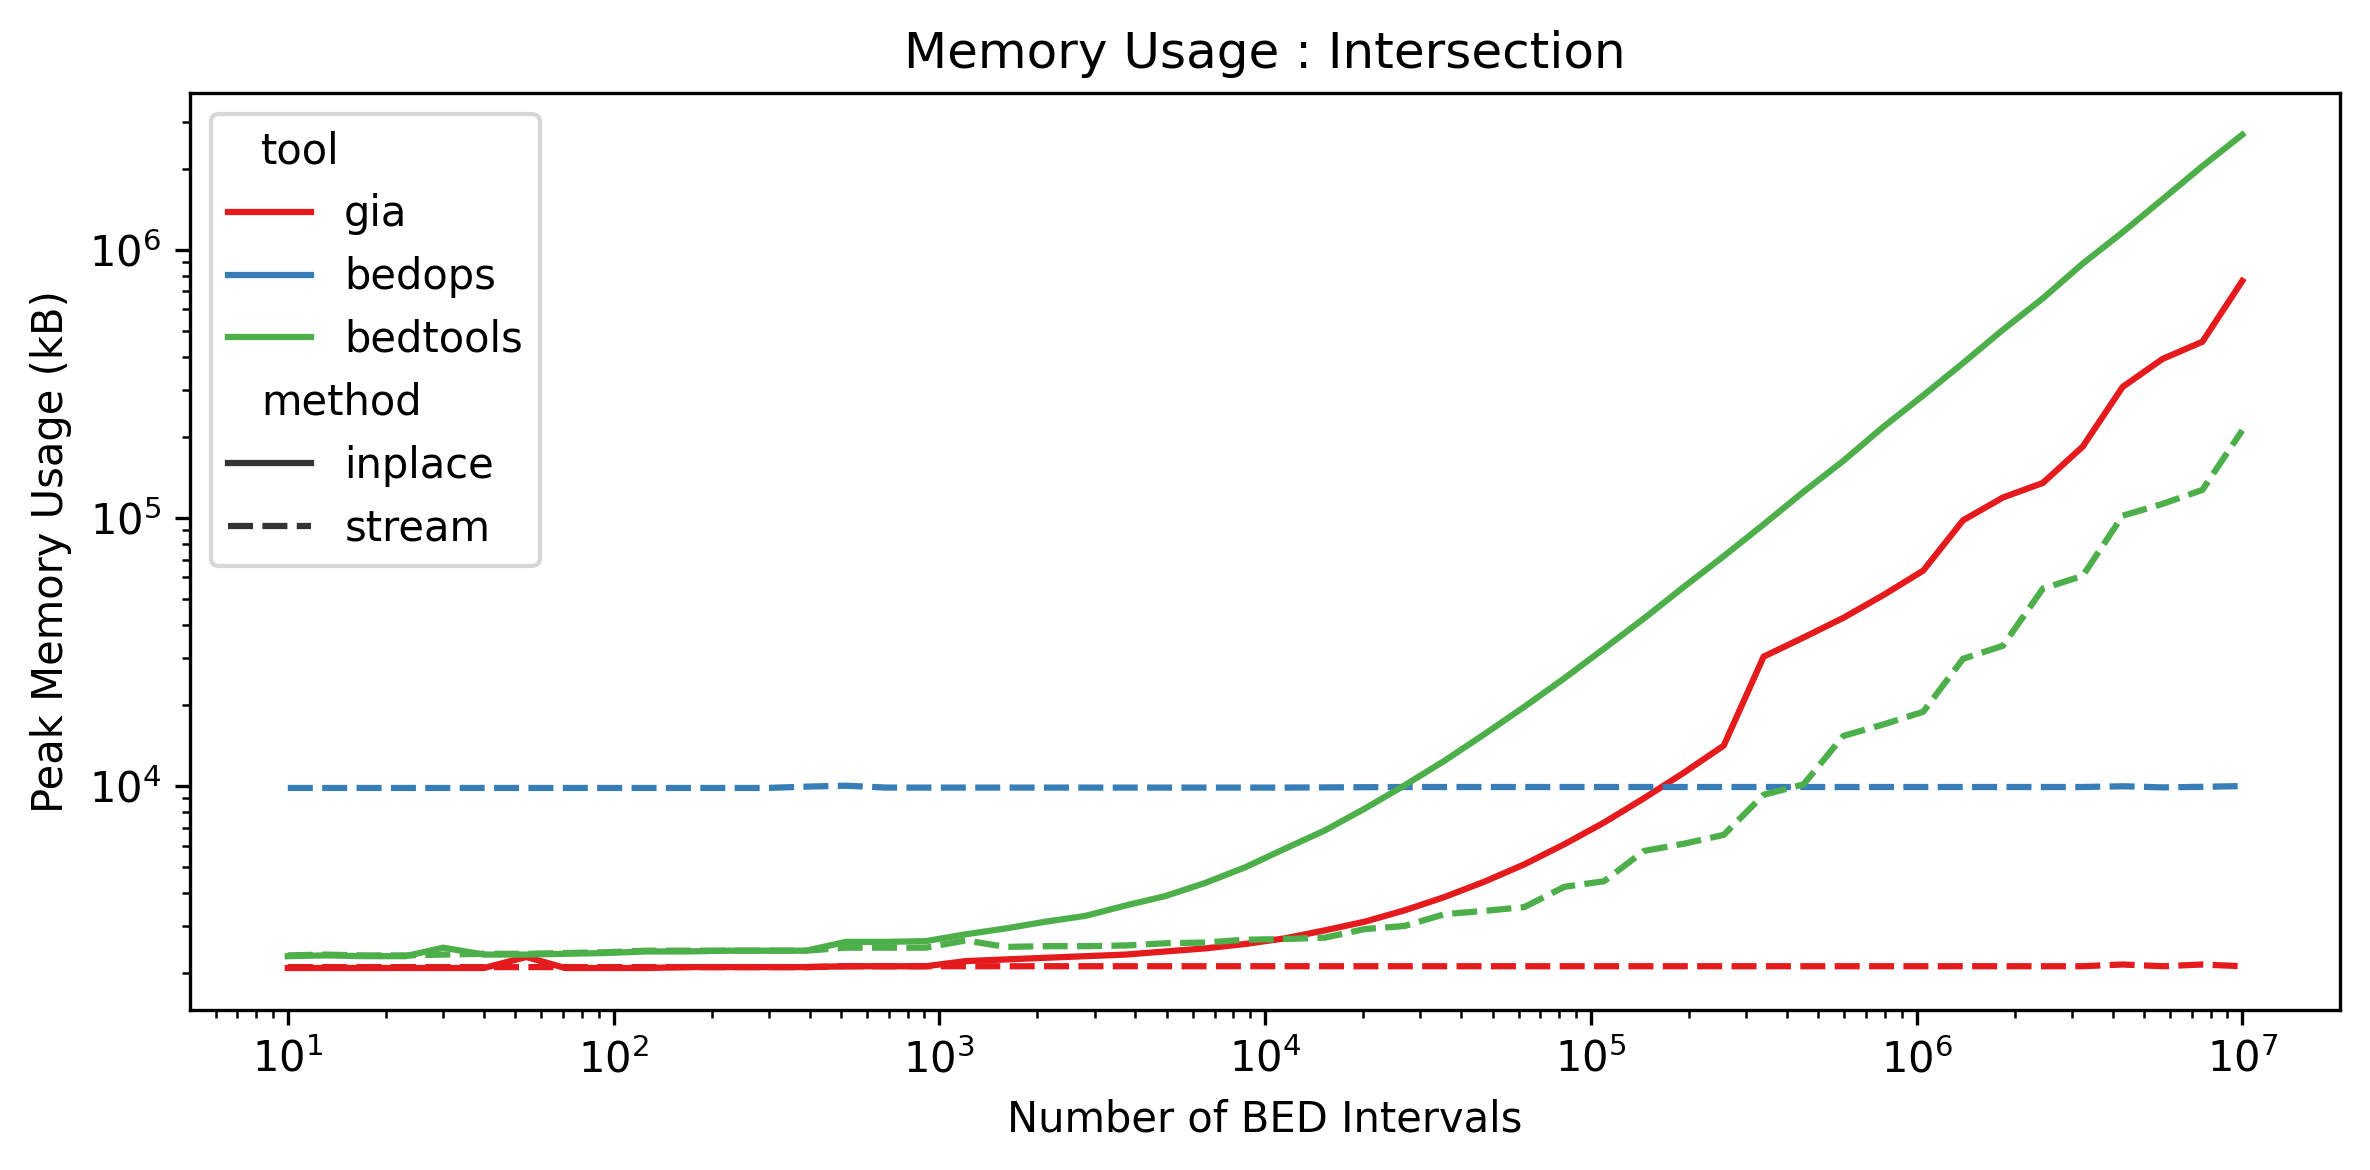

In [8]:
plt.figure(figsize=(8, 4), dpi=300)
sns.lineplot(
    data=frame,
    x="num_rows",
    y="mem",
    hue="tool",
    style="method",
    palette="Set1",
    hue_order=["gia", "bedops", "bedtools"],
    style_order=["inplace", "stream"]
)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Peak Memory Usage (kB)")
plt.xlabel("Number of BED Intervals")
plt.title("Memory Usage : Intersection")
plt.tight_layout()
plt.savefig("figures/intersection_memory.svg")
plt.savefig("figures/intersection_memory.png")
plt.show()

In [9]:
frame[frame.method == "stream"].groupby("tool").apply(lambda x: x.mem.mean())

tool
bedops       9893.12
bedtools    18279.36
gia          2124.80
dtype: float64

In [10]:
def classify_memory_usage(x):
    if "bedops" in x:
        return "stream"
    if "gia" in x:
        if "-S" in x:
            return "stream"
        else:
            return "inplace"
    if "bedtools" in x:
        if "-sorted" in x:
            return "stream"
        else:
            return "inplace"

timing_frame = []
for fn in glob.glob("results/intersect_range_*.csv"):
    num_iv = int(fn.split("_")[-1].split(".")[0])
    try:
        subframe = pd.read_csv(fn)
        subframe["num_rows"] = num_iv
        timing_frame.append(subframe)
    except:
        print(fn)
    
timing_frame = pd.concat(timing_frame)
timing_frame["tool"] = timing_frame.command.apply(lambda x: x.split(" ")[0])
timing_frame["method"] = timing_frame.command.apply(lambda x: classify_memory_usage(x))
timing_frame["named"] = frame.tool + "_" + frame.method
timing_frame

,command,mean,stddev,median,user,system,min,max,num_rows,tool,method,named
0,gia intersect -S -a data/random_a_750.bed -b d...,0.001466,0.000076,0.001424,0.000658,0.000527,0.001419,0.001553,750,gia,stream,gia_inplace
1,bedops -i data/random_a_750.bed data/random_b_...,0.002777,0.000140,0.002802,0.001210,0.001260,0.002625,0.002903,750,bedops,stream,gia_stream
0,gia intersect -S -a data/random_a_7500.bed -b ...,0.002387,0.000011,0.002391,0.001715,0.000448,0.002375,0.002396,7500,gia,stream,gia_inplace
1,bedops -i data/random_a_7500.bed data/random_b...,0.005909,0.000178,0.005918,0.004002,0.001504,0.005726,0.006082,7500,bedops,stream,gia_stream
0,gia intersect -S -a data/random_a_50000000.bed...,6.137503,0.007850,6.141528,5.816783,0.318956,6.128457,6.142525,50000000,gia,stream,gia_inplace
...,...,...,...,...,...,...,...,...,...,...,...,...
2,bedtools intersect -a data/random_a_2500000.be...,19.588526,0.016356,19.596673,19.381893,0.201330,19.569697,19.599207,2500000,bedtools,inplace,bedtools_inplace
0,gia intersect -S -a data/random_a_500000.bed -...,0.078423,0.000313,0.078340,0.074469,0.003534,0.078160,0.078769,500000,gia,stream,gia_inplace
1,bedops -i data/random_a_500000.bed data/random...,0.219938,0.001212,0.219692,0.211412,0.007706,0.218867,0.221254,500000,bedops,stream,gia_stream
0,gia intersect -S -a data/random_a_100.bed -b d...,0.001199,0.000141,0.001187,0.000527,0.000420,0.001064,0.001346,100,gia,stream,gia_inplace


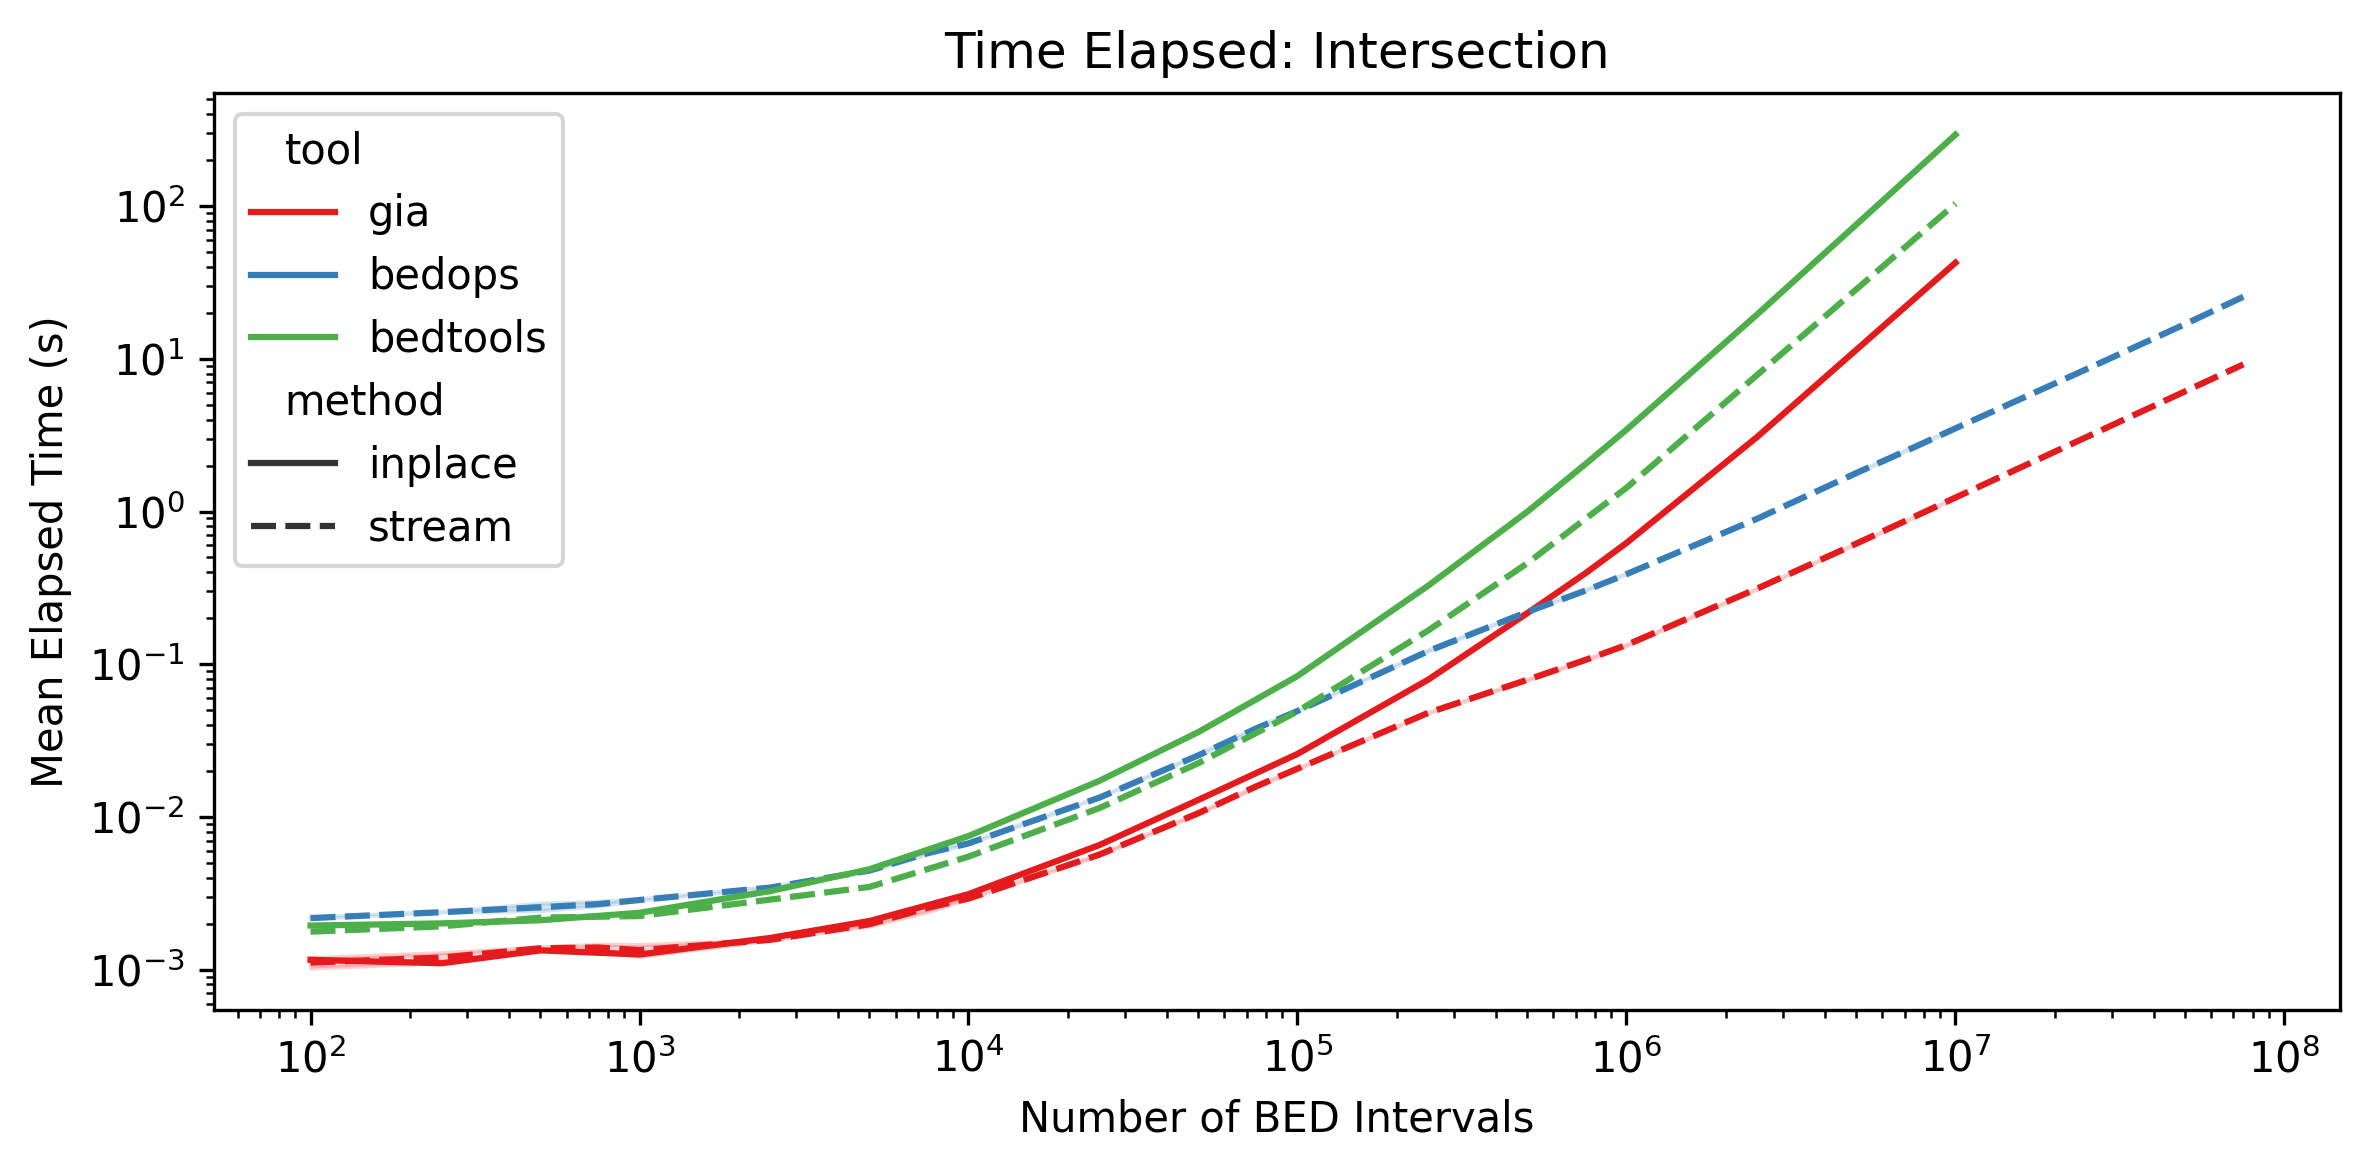

In [11]:
plt.figure(figsize=(8,4), dpi=300)
sns.lineplot(
    data=timing_frame,
    x="num_rows",
    y="mean",
    hue="tool",
    style="method",
    palette="Set1",
    hue_order=["gia", "bedops", "bedtools"], 
    style_order=["inplace", "stream"]

)
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Mean Elapsed Time (s)")
plt.xlabel("Number of BED Intervals")
plt.title("Time Elapsed: Intersection")
plt.tight_layout()
plt.savefig("figures/intersection_compute.svg")
plt.savefig("figures/intersection_compute.png")
plt.show()